In [19]:
import json
import matplotlib.pyplot as plt
import numpy as np

import sys  
sys.path.insert(1, 'funcs')
import ScalarField
import TangentPoint
import TangentPointSet

In [20]:
f = open("tangentmaps/breast_cancer.tmap","r")
dataImport = json.loads(f.read())
tmap = dataImport['tmap']
Col_labels = dataImport['Col_labels']

data = dataImport

# print(data['tmap'][0])
# print(data['Col_labels'])

In [21]:
# First pass: Create Point instances with any initial scale_factor (e.g., 1.0)
points = []
for tmap_entry in tmap:
    point = TangentPoint.TangentPoint(tmap_entry, 1.0, Col_labels)
    points.append(point)

# Collect all gradient vectors and positions from the Point instances
all_positions = np.array([point.position for point in points if point.valid])  # Shape: (M, 2)
all_gradient_vectors = np.vstack([point.gradient_vectors for point in points if point.valid])  # Shape: (total_num_vectors, 2)

# Compute maximum gradient vector length
gradient_lengths = np.linalg.norm(all_gradient_vectors, axis=1)
max_gradient_length = np.max(gradient_lengths)

# Compute position ranges
x_range = np.max(all_positions[:, 0]) - np.min(all_positions[:, 0])
y_range = np.max(all_positions[:, 1]) - np.min(all_positions[:, 1])
position_range = max(x_range, y_range)

# Decide on desired fraction of position range for maximum gradient length
desired_fraction = 0.05  # Adjust as necessary

# Compute scale factor
scale_factor = (position_range * desired_fraction) / max_gradient_length
print("Computed scale factor:", scale_factor)

# Update scale factor in each Point instance
for point in points:
    if point.valid:
        point.update_scale_factor(scale_factor)

Computed scale factor: 0.6178953731105454


# Vector Field

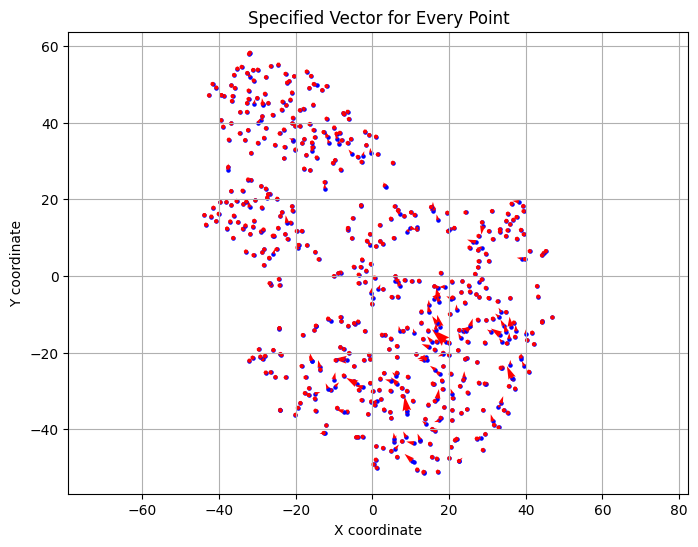

In [22]:
vector_index = 2

plt.figure(figsize=(8, 6))

for point in points:
    px, py = point.position[0], point.position[1]
    vx = point.gradient_vectors[vector_index][0]
    vy = point.gradient_vectors[vector_index][1]

    plt.scatter(px, py, color='blue', s=5)
    plt.quiver(px, py, vx, vy, angles='xy', scale_units='xy', scale=1, color='red')

plt.title("Specified Vector for Every Point")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.grid(True)
plt.axis('equal')
plt.show()

# Maximum Contour Region

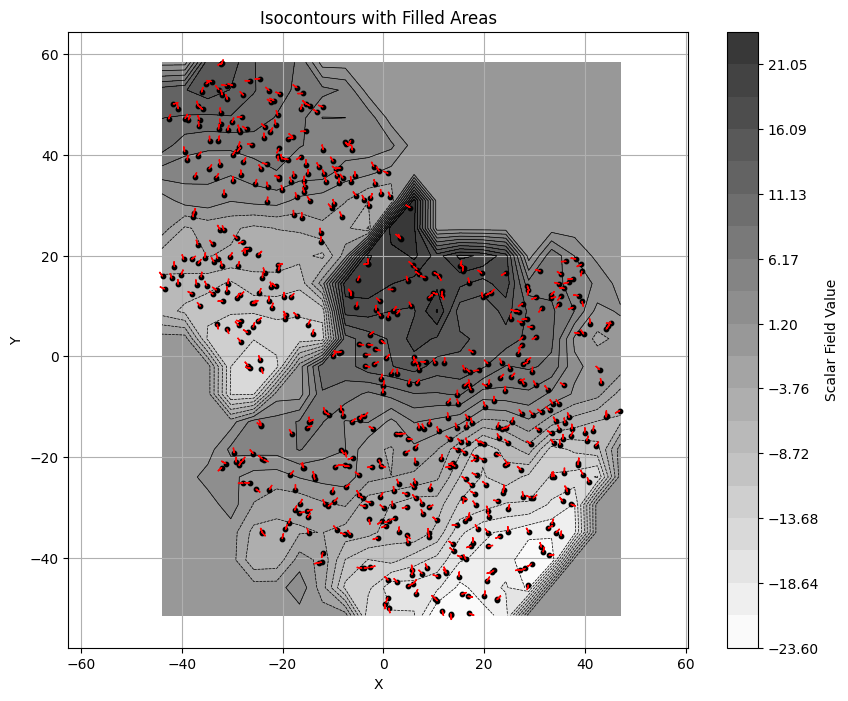

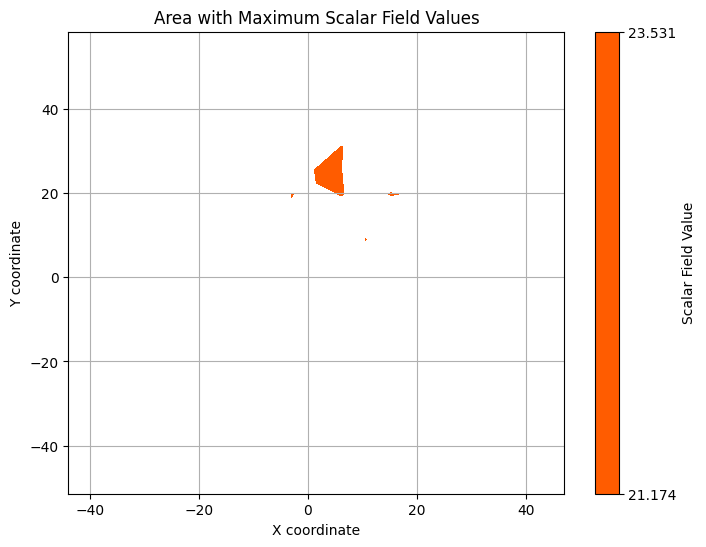

In [23]:
# Call the function with the points
feature_idx = 2
f_grid, X_grid, Y_grid, contour_levels = ScalarField.reconstruct_scalar_field(points, grid_size=20, feature_index=feature_idx)

fig, ax = plt.subplots(figsize=(10, 8))

# Create a colormap
cmap = plt.get_cmap('binary')

# Plot filled contours
contourf = ax.contourf(X_grid, Y_grid, f_grid, levels=contour_levels, cmap=cmap, alpha=0.8)

# Plot contour lines on top
contours = ax.contour(X_grid, Y_grid, f_grid, levels=contour_levels, colors='k', linewidths=0.5)

# Add a colorbar
cbar = fig.colorbar(contourf, ax=ax)
cbar.set_label('Scalar Field Value')

# Plot the point positions
positions = np.array([point.position for point in points if point.valid])
ax.scatter(positions[:, 0], positions[:, 1], c='black', s=10, zorder=5)

# Optionally plot the gradient vectors
for point in points:
    if point.valid:
        x, y = point.position
        # Using the same selected gradient as in the function
        gradients = point.gradient_vectors
        magnitudes = np.linalg.norm(gradients, axis=1)
        max_idx = np.argmax(magnitudes)
        gi = gradients[feature_idx]
        gi_norm = np.linalg.norm(gi)
        if gi_norm != 0:
            gi_unit = gi / gi_norm
        else:
            gi_unit = gi
        arrow_scale = 1
        ax.arrow(
            x, y,
            gi_unit[0] * arrow_scale, gi_unit[1] * arrow_scale,
            head_width=0.1,
            head_length=0.1,
            fc='red',
            ec='red',
            length_includes_head=True,
            zorder=6
        )

ax.set_title('Isocontours with Filled Areas')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.axis('equal')
plt.grid(True)
plt.show()

# Assume f_grid, X_grid, Y_grid, _ are obtained from reconstruct_scalar_field(...)
max_val = np.nanmax(f_grid)
min_val = np.nanmin(f_grid)
tolerance = 0.05 * (max_val - min_val)  # adjust 5% threshold as desired
threshold = max_val - tolerance

plt.figure(figsize=(8, 6))
plt.contourf(X_grid, Y_grid, f_grid, levels=[threshold, max_val], cmap='hot')
plt.colorbar(label="Scalar Field Value")
plt.title("Area with Maximum Scalar Field Values")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.grid(True)
plt.show()

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import matplotlib.colors as mcolors

n = 5  # Number of top features to select

feature_count = len(Col_labels)
# Generate colors for all features, then subset based on top n features.
all_colors = plt.cm.tab10(np.linspace(0, 1, feature_count))

feature_max_vals = []
grid_size = 30

# Compute maximum value for each feature
for feature_idx in range(feature_count):
    f_grid_feature, _, _, _ = ScalarField.reconstruct_scalar_field(points, grid_size=grid_size, feature_index=feature_idx)
    max_val = np.nanmax(f_grid_feature)
    feature_max_vals.append(max_val)

# Get indices of top n features with highest max values.
top_n_indices = np.argsort(feature_max_vals)[::-1][:n]
selected_features = top_n_indices.tolist()
selected_colors = all_colors[selected_features]

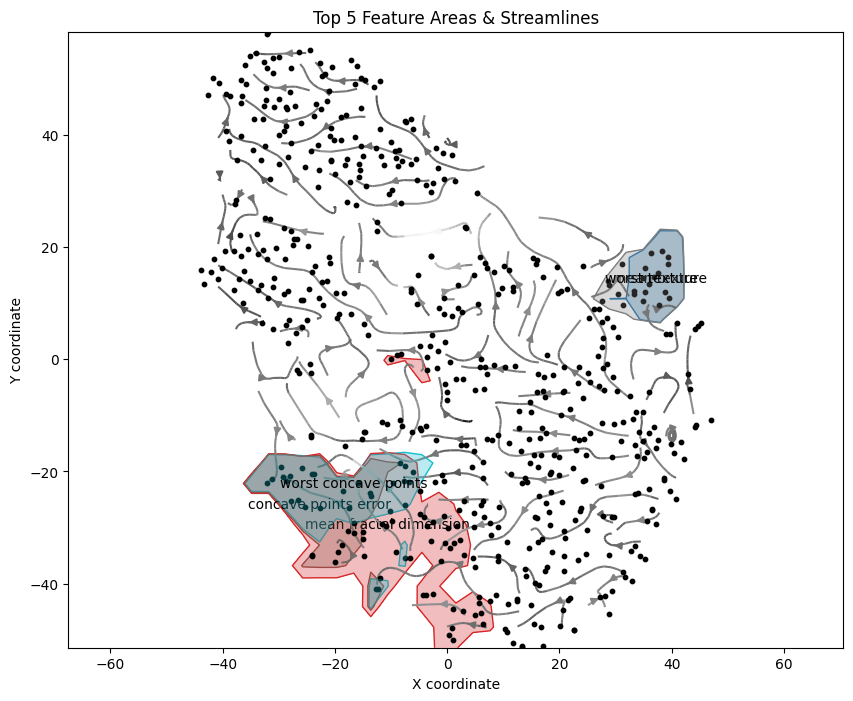

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import matplotlib.colors as mcolors

n = 5  # Number of top features to select
feature_count = len(Col_labels)
all_colors = plt.cm.tab10(np.linspace(0, 1, feature_count))  # Colors for all features

grid_size = 30
feature_max_vals = []

# Compute maximum value for each feature
for feature_idx in range(feature_count):
    f_grid_feature, _, _, _ = ScalarField.reconstruct_scalar_field(points, grid_size=grid_size, feature_index=feature_idx)
    max_val = np.nanmax(f_grid_feature)
    feature_max_vals.append(max_val)

# Get indices of top n features with highest max values.
top_n_indices = np.argsort(feature_max_vals)[::-1][:n]
selected_features = top_n_indices.tolist()
selected_colors = all_colors[selected_features]

fig, ax = plt.subplots(figsize=(10, 8))
# Use one of the selected features to set the grid reference.
f_grid, X_grid, Y_grid, contour_levels = ScalarField.reconstruct_scalar_field(
    points, grid_size=grid_size, feature_index=selected_features[0]
)

for i, feature_idx in enumerate(selected_features):
    # Reconstruct the scalar field for the current feature.
    f_grid_feature, _, _, _ = ScalarField.reconstruct_scalar_field(
        points, grid_size=grid_size, feature_index=feature_idx
    )
    
    # Define threshold near the maximum value.
    max_val = np.nanmax(f_grid_feature)
    min_val = np.nanmin(f_grid_feature)
    tolerance = 0.3 * (max_val - min_val)  # adjust tolerance as desired
    threshold = max_val - tolerance
    
    # Plot filled contour for regions with high values for the current feature.
    ax.contourf(
        X_grid, Y_grid, f_grid_feature,
        levels=[threshold, max_val],
        colors=[selected_colors[i]],
        alpha=0.3, zorder=feature_idx
    )
    
    # Optionally display contour lines for the maximum region.
    ax.contour(
        X_grid, Y_grid, f_grid_feature,
        levels=[threshold, max_val],
        colors=[selected_colors[i]], linewidths=1
    )
    
    # Add label to this contour.
    mask = f_grid_feature >= threshold
    if np.any(mask):
        label_x = np.median(X_grid[mask])
        label_y = np.median(Y_grid[mask])
        ax.text(label_x, label_y, Col_labels[feature_idx],
                color='black', fontsize=10, ha='center', va='center',
                zorder=feature_idx+1)

# Plot the underlying point positions for reference.
positions = np.array([point.position for point in points if point.valid])
ax.scatter(positions[:, 0], positions[:, 1], c='black', s=10, zorder=20)

# Sum all gradient vectors for each valid point.
gradient_list = np.array([np.sum(point.gradient_vectors, axis=0) for point in points if point.valid])

# Interpolate the gradient vectors onto the scalar field grid (X_grid, Y_grid).
grid_gx = griddata((positions[:, 0], positions[:, 1]), gradient_list[:, 0], (X_grid, Y_grid), method='cubic')
grid_gy = griddata((positions[:, 0], positions[:, 1]), gradient_list[:, 1], (X_grid, Y_grid), method='cubic')

# Compute the magnitude and normalize it.
hyp = np.hypot(grid_gx, grid_gy)
valid_min = np.nanmin(hyp)
valid_max = np.nanmax(hyp)
filled_hyp = np.where(np.isnan(hyp), valid_min, hyp)
norm = mcolors.PowerNorm(gamma=0.2, vmin=valid_min, vmax=valid_max)
normed_hyp = norm(filled_hyp)

# Overlay streamlines using the scalar field grid.
strm = ax.streamplot(X_grid, Y_grid, grid_gx, grid_gy, density=1,
                     color=normed_hyp, cmap='gray', zorder=10)

ax.set_title('Top {} Feature Areas & Streamlines'.format(n))
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.axis('equal')
plt.grid(False)
plt.show()

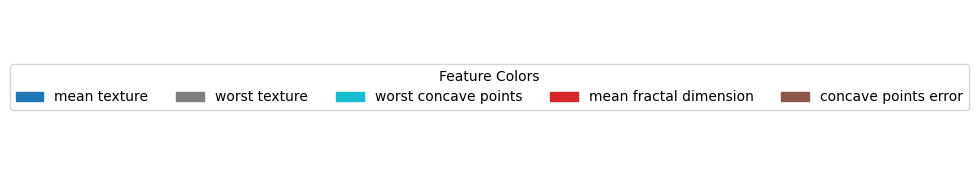

In [26]:
import matplotlib.patches as mpatches

plt.show()

# Create a separate plot for the legend (color-label relationship)
fig_legend, ax_legend = plt.subplots(figsize=(6, 2))
ax_legend.axis('off')  # Hide the axis

# Build legend handles using the selected colors and feature indices.
legend_handles = [
    mpatches.Patch(color=selected_colors[i], label=Col_labels[selected_features[i]])
    for i in range(n)
]
ncol = 6 if n > 6 else n
ax_legend.legend(handles=legend_handles, loc='center', ncol=ncol, title="Feature Colors")

plt.show()

# Global threshold

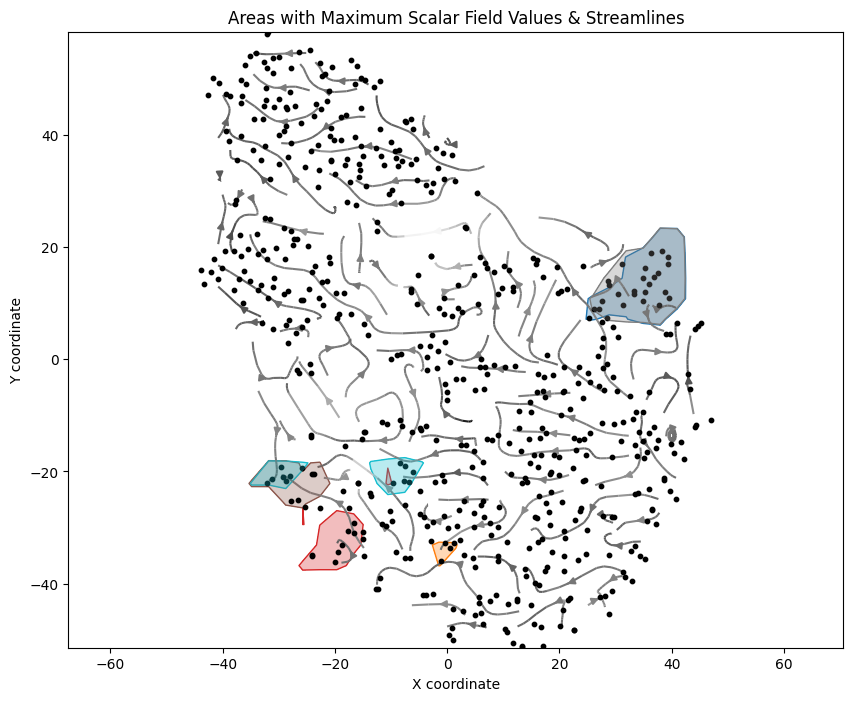

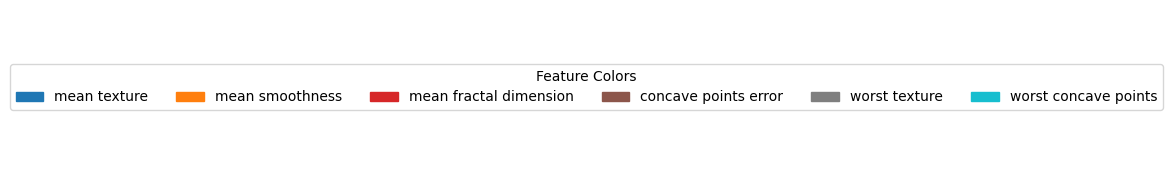

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

feature_count = len(Col_labels)
colors = plt.cm.tab10(np.linspace(0, 1, feature_count))  # Discrete colors for each feature

fig, ax = plt.subplots(figsize=(10, 8))
grid_size = 30

# Compute one scalar field to get the grid reference.
f_grid, X_grid, Y_grid, contour_levels = ScalarField.reconstruct_scalar_field(points, grid_size=grid_size, feature_index=0)

# Precompute global max and min across all features.
global_max = -np.inf
global_min = np.inf
for feature_idx in range(feature_count):
    f_grid_feature, _, _, _ = ScalarField.reconstruct_scalar_field(points, grid_size=grid_size, feature_index=feature_idx)
    global_max = max(global_max, np.nanmax(f_grid_feature))
    global_min = min(global_min, np.nanmin(f_grid_feature))

# Define a global threshold based on the overall max and min.
tolerance = 0.3 * (global_max - global_min)  # adjust as needed
global_threshold = global_max - tolerance

# Record used feature indices (only features with some region above the threshold)
used_features = []

for feature_idx in range(feature_count):
    # Reconstruct the scalar field for the current feature using the same grid size.
    f_grid_feature, _, _, _ = ScalarField.reconstruct_scalar_field(points, grid_size=grid_size, feature_index=feature_idx)
    
    # Check if this feature has values above the global threshold.
    if np.any(f_grid_feature >= global_threshold):
        used_features.append(feature_idx)
        # Use the global threshold for all features.
        ax.contourf(X_grid, Y_grid, f_grid_feature,
                    levels=[global_threshold, global_max],
                    colors=[colors[feature_idx]],
                    alpha=0.3, zorder=feature_idx)
        
        # Optionally display contour lines for the maximum region.
        ax.contour(X_grid, Y_grid, f_grid_feature,
                   levels=[global_threshold, global_max],
                   colors=[colors[feature_idx]], linewidths=1)

# Plot the underlying point positions for reference.
positions = np.array([point.position for point in points if point.valid])
ax.scatter(positions[:, 0], positions[:, 1], c='black', s=10, zorder=20)

# === Use the same grid (X_grid, Y_grid) from the scalar field for streamlines ===
# Sum all gradient vectors for each valid point.
gradient_list = np.array([np.sum(point.gradient_vectors, axis=0) for point in points if point.valid])

# Interpolate the gradient vectors onto the scalar field grid (X_grid, Y_grid).
grid_gx = griddata((positions[:, 0], positions[:, 1]), gradient_list[:, 0],
                   (X_grid, Y_grid), method='cubic')
grid_gy = griddata((positions[:, 0], positions[:, 1]), gradient_list[:, 1],
                   (X_grid, Y_grid), method='cubic')

# Compute the magnitude (hypot) and normalize it.
hyp = np.hypot(grid_gx, grid_gy)
valid_min = np.nanmin(hyp)
valid_max = np.nanmax(hyp)
filled_hyp = np.where(np.isnan(hyp), valid_min, hyp)
norm = mcolors.PowerNorm(gamma=0.2, vmin=valid_min, vmax=valid_max)
normed_hyp = norm(filled_hyp)

# Overlay streamlines using the scalar field grid.
strm = ax.streamplot(X_grid, Y_grid, grid_gx, grid_gy, density=1,
                     color=normed_hyp, cmap='gray', zorder=10)

ax.set_title('Areas with Maximum Scalar Field Values & Streamlines')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.axis('equal')
plt.grid(False)
plt.show()


# Create a separate figure for the legend including only the used features.
legend_handles = [mpatches.Patch(color=colors[i], label=Col_labels[i]) for i in used_features]
fig_legend, ax_legend = plt.subplots(figsize=(6, 2))
ax_legend.axis('off')  # Hide the axis

# Limit legend to a maximum of 6 entries per row.
ncols = 6 if len(legend_handles) > 6 else len(legend_handles)
ax_legend.legend(handles=legend_handles, loc='center', ncol=ncols, title="Feature Colors")
plt.show()